In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [7]:
# Define autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)

In [8]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        
        output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.7132
Epoch [2/10], Loss: 0.6733
Epoch [3/10], Loss: 0.6589
Epoch [4/10], Loss: 0.6456
Epoch [5/10], Loss: 0.6206
Epoch [6/10], Loss: 0.6287
Epoch [7/10], Loss: 0.6444
Epoch [8/10], Loss: 0.6539
Epoch [9/10], Loss: 0.6204
Epoch [10/10], Loss: 0.6106


In [9]:
# Load test datset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
dataiter = iter(test_loader)
images, _ = next(dataiter)

# Set the model to evaluation mode
model.eval()

# Image reconstruction
with torch.no_grad():
    images = images.to(device)
    reconstructed = model(images)

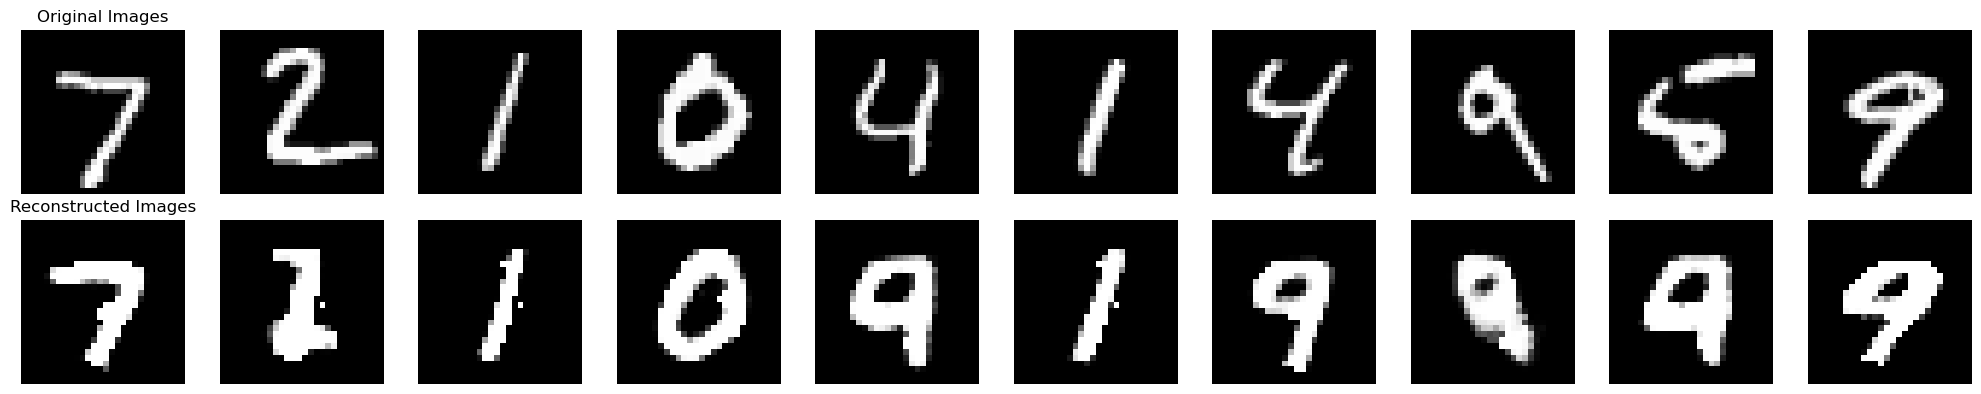

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Visualization
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

for i in range(10):
    # Original images
    axes[0][i].imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
    axes[0][i].axis('off')
    if i == 0:
        axes[0][i].set_title('Original Images')
        
    # Reconstructed images
    axes[1][i].imshow(reconstructed[i].cpu().squeeze().numpy(), cmap='gray')
    axes[1][i].axis('off')
    if i == 0:
        axes[1][i].set_title('Reconstructed Images')
        
plt.tight_layout()
plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()) # binarize
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Define masked convolution
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type='A', **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0
    
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [13]:
# Define PixelCNN
class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, n_filters=64, n_layers=7):
        super(PixelCNN, self).__init__()
        self.layers = nn.ModuleList([
            MaskedConv2d(input_channels, n_filters, 7, 1, 3, mask_type='A'),
            nn.ReLU()
        ])
        for _ in range(n_layers - 2):
            self.layers.extend([
                MaskedConv2d(n_filters, n_filters, 3, 1, 1, mask_type='B'),
                nn.ReLU()
            ])
        self.layers.append(MaskedConv2d(n_filters, input_channels, 1, 1, 0, mask_type='B'))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
